In [27]:
###############################################################################################
# Versión 3b
# SEGUN LOS "n" DIAS PREVIOS (VENTANA DE "n" VALORES), PREDICE los "ventSalida" DÍAS SIGUIENTES
# del atributo seleccionado
#
# Se añade la evaluación del modelo ======>>>> la evaluación no funciona correctamente
#
###############################################################################################

In [28]:
# Parámetros del algoritmo

# Definir el número de días de la ventana de entrada (días previos a considerar para la predicción)
n = 30

# Definir el número de días a predecir por cada ventana de entrada
ventSalida = 1

# seleccionar un atributo a predecir
atributo = 'PM10'

# Definir número de epoch máximo para entrenamiento
max_epochs = 50

In [29]:
# librerías necesarias

import pandas as pd
import numpy as np
import plotly 
import plotly.express as px
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

np.random.seed(12345)

# Configuración general de las figuras que representaremos
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 10)

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
path = '/content/drive/MyDrive/datoscsv/'
df = pd.read_csv(path + 'airWeather_2013-2019_v3.csv', sep=';', index_col='FECHA', parse_dates=['FECHA'])

# Recuperar la fecha como campo
df.insert(0, 'FECHA', df.index.strftime('%Y-%m-%d'))

In [32]:
# seleccionar solo una estación de las cuatro disponibles para hacer pruebas
df = df[df['COD_ESTACION']==46250043]
df.isnull().sum()

FECHA             0
COD_ESTACION      0
NOM_ESTACION      0
SO2             144
NO              165
NO2             165
NOx             165
O3               51
PM10            171
PM2.5           214
lluvias         143
Temp            143
VelocVent       143
dtype: int64

In [33]:
# eliminar filas sin el atributo para probar

df = df[df[atributo].notnull()]

df.isnull().sum()

FECHA             0
COD_ESTACION      0
NOM_ESTACION      0
SO2             136
NO              165
NO2             165
NOx             165
O3               44
PM10              0
PM2.5            63
lluvias         136
Temp            136
VelocVent       136
dtype: int64

In [34]:
df

,FECHA,COD_ESTACION,NOM_ESTACION,SO2,NO,NO2,NOx,O3,PM10,PM2.5,lluvias,Temp,VelocVent
FECHA,,,,,,,,,,,,,
2013-01-01,2013-01-01,46250043,VALÈNCIA VIVERS,1.0,5.0,30.0,39.0,27.0,6.0,5.0,0.0,13.70,0.6
2013-01-02,2013-01-02,46250043,VALÈNCIA VIVERS,6.0,83.0,85.0,211.0,16.0,18.0,6.0,0.0,11.40,0.6
2013-01-03,2013-01-03,46250043,VALÈNCIA VIVERS,3.0,32.0,69.0,117.0,16.0,18.0,12.0,NaN,NaN,NaN
2013-01-04,2013-01-04,46250043,VALÈNCIA VIVERS,4.0,50.0,79.0,156.0,12.0,19.0,13.0,NaN,NaN,NaN
2013-01-05,2013-01-05,46250043,VALÈNCIA VIVERS,3.0,47.0,75.0,147.0,9.0,22.0,16.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,2019-12-27,46250043,VALÈNCIA VIVERS,3.0,21.0,42.0,74.0,12.0,26.0,21.0,0.0,13.55,7.0
2019-12-28,2019-12-28,46250043,VALÈNCIA VIVERS,3.0,19.0,40.0,69.0,16.0,34.0,23.0,0.0,10.55,9.0
2019-12-29,2019-12-29,46250043,VALÈNCIA VIVERS,3.0,3.0,27.0,32.0,27.0,41.0,23.0,0.0,11.75,8.0


In [35]:
# Modelo LSTM

In [36]:
# Vamos a coger del 2013 al 2018 para entrenamiento y los datos del 2019 para testear
# Para poder introducir los datos en una red neuronal hay que transformarlos, ya que solo funciona con arrays
df2 = df[[atributo]]
train = df2[:'2018']    # guardar desde fecha más antigua hasta final de 2018
test = train.iloc[-n:]  # guardar los "n" últimos dias del 2018
test = test.append(df2['2019'], ignore_index=False) # añadir a los últimos "n" días del 2018 + el 2019 completo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  


In [37]:
train

,PM10
FECHA,
2013-01-01,6.0
2013-01-02,18.0
2013-01-03,18.0
2013-01-04,19.0
2013-01-05,22.0
...,...
2018-12-27,22.0
2018-12-28,19.0
2018-12-29,21.0


In [38]:
test

,PM10
FECHA,
2018-12-02,20.0
2018-12-03,31.0
2018-12-04,26.0
2018-12-05,32.0
2018-12-06,24.0
...,...
2019-12-27,26.0
2019-12-28,34.0
2019-12-29,41.0


In [39]:
df2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PM10,2385.0,22.898952,10.398572,2.0,16.0,22.0,28.0,127.0


In [40]:
# Tiene que ser un vector columna
train.shape

(2029, 1)

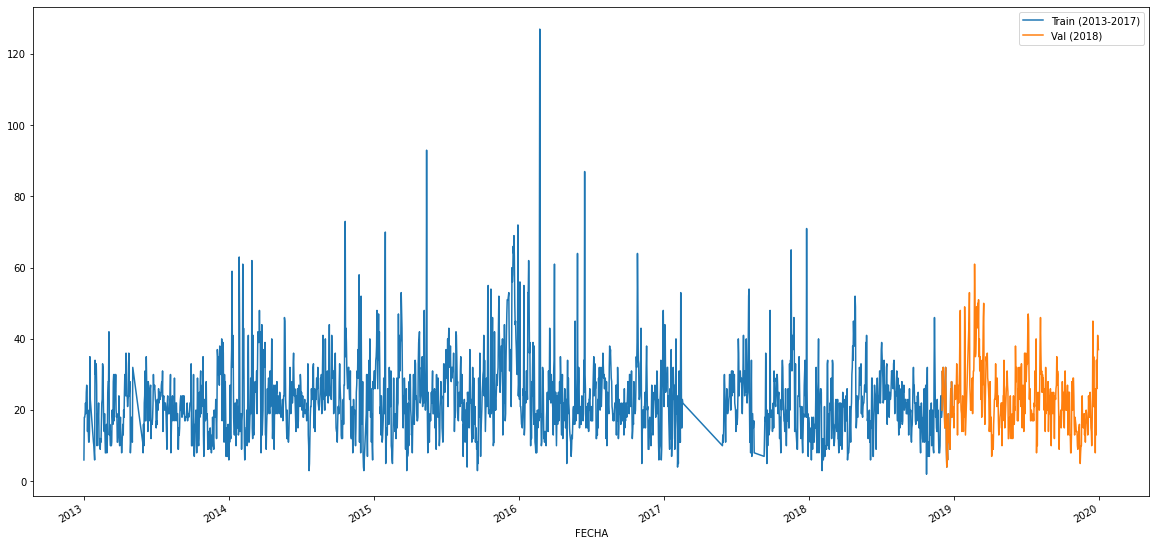

In [41]:
train[atributo].plot(legend=True)
test[atributo].plot(legend=True)

plt.legend(['Train (2013-2017)', 'Val (2018)', 'Test (2019)'])
plt.show()

## **Normalización**

In [42]:
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train)

## **Estructura datos entrada**

In [43]:
# Hay que crear una estructura de datos para indicarle a la red lo que tiene que recordar 
# y poder hacer una predección en base a datos anteriores
X_train = []
y_train = []

# Estructura de datos con "n" pasos y un valor de salida
# "n" timesteps significa que para un día dado la red es capaz de mirar los "n" días anteriores:
# "n" valores anteriores al día actual y en base a esa información predice el valor futuro 
for i in range(n,len(train_scaled)):
    # X: para cada día hacemos un bloque correspondiente al valor de los "n" días anteriores
    X_train.append(train_scaled[i-n:i,0])
    # Y: el valor del día
    y_train.append(train_scaled[i,0])

# Tenemos una matriz donde cada fila contiene "n" columnas correspondientes a los "n" días anteriores
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape X_train para que se ajuste al modelo en Keras
# añadiendo una nueva dimensión 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1999, 30, 1)

## **Modelo**

Creamos un modelo secuencial al que iremos añadiendo capas, que pueden ser:

*   Dense: Capa de neuronas artificiales
*   LSTM: Capa de neuronas con capacidad de memoria
*   Dropout: Es una técnica de regularización que elimina conexiones neuronales para evitar el sobreajuste, de esta forma se evita que el algoritmo memorice los datos en vez de aprender de ellos. 

Antes de crear la Red LSTM debemos reajustar los sets que acabamos de obtener, para indicar que cada ejemplo de entrenamiento a la entrada del modelo será un vector de "n" x 1.

Para el caso de cada una de las salidas (almacenadas en y_train) debemos simplemente especificar que su tamaño, que será igual al número de valores predichos por la red neuronal.

In [44]:
# Definimos el tamaño de los datos de entrada y de salida
dim_entrada = (X_train.shape[1],1)
# santi
# dim_salida = 1 
dim_salida = ventSalida

modelo = Sequential()
# Añadimos la primera capa y especificamos el número de neuromas (50) y el tamaño de cada dato de entrada
modelo.add(LSTM (units=50, return_sequences=True, input_shape=dim_entrada))
modelo.add(Dropout(0.2))
# Añadimos la segunda capa
modelo.add(LSTM (units=50, return_sequences=True))
modelo.add(Dropout(0.2))
# Añadimos la tercera capa
modelo.add(LSTM (units=50, return_sequences=True))
modelo.add(Dropout(0.2))
# Añadimos la cuarta capa
modelo.add(LSTM (units=50))
modelo.add(Dropout(0.2))
# Añadimos la capa de salida (Dense) y especificamos que el campo de salida es igual a dim_salida
modelo.add(Dense(units=dim_salida))

## **Compilación**

*   El optimizador se encarga de optimizar y actualizar los pesos de la red. Usaremos el algoritmo adam que es el que mejores resultados nos aporta.
*   loss: Cuando la red hace una predicción coge el valor real y lo compará con la predicción. Para calcular el error de predicción, se utilizará el método error cuadrático medio. 

In [45]:
# Compilamos el modelo definiendo la función de error (loss) y el método que se usa para minimizarla (optimizer)
modelo.compile(optimizer='adam', loss='mean_squared_error')

## **Entrenamiento**

*   epochs: Especificamos las veces que la red propagara el error hacia atrás para aprender y hacer mejores predicciones. Es la cantidad de veces que la red realizará una predicción y propagara hacia atrás el error, para aprender de él y hacer mejores predicciones
*   batch_size: Para este proceso de predicción, corrección y propagación hacia atrás, no lo haremos con un solo bloque de datos, si no de 32. Si no el entrenamiento sería demasiado pesado para la red, el tener que actualizar los pesos a cada dato. Vamos actualizando los pesos con bloques de datos.

In [46]:
# Entrenamos el modelo con epochs=epoch_max (nº de iteraciones) y batch_size=32 (lotes de 32 datos)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

modelo.fit(X_train,y_train,epochs=max_epochs, batch_size=32, callbacks=[callback])

Epoch 1/50
63/63 [==============================] - 11s 61ms/step - loss: 0.0086
Epoch 2/50
63/63 [==============================] - 4s 61ms/step - loss: 0.0075
Epoch 3/50
63/63 [==============================] - 4s 60ms/step - loss: 0.0073
Epoch 4/50
63/63 [==============================] - 4s 61ms/step - loss: 0.0073
Epoch 5/50
63/63 [==============================] - 4s 61ms/step - loss: 0.0073
Epoch 6/50
63/63 [==============================] - 4s 61ms/step - loss: 0.0072
Epoch 7/50
63/63 [==============================] - 4s 62ms/step - loss: 0.0072
Epoch 8/50
63/63 [==============================] - 4s 60ms/step - loss: 0.0069
Epoch 9/50
63/63 [==============================] - 4s 61ms/step - loss: 0.0070
Epoch 10/50
63/63 [==============================] - 4s 60ms/step - loss: 0.0069
Epoch 11/50
63/63 [==============================] - 4s 61ms/step - loss: 0.0067
Epoch 12/50
63/63 [==============================] - 4s 60ms/step - loss: 0.0067
Epoch 13/50
63/63 [=================

## **Predicciones**

Hay que preparar los datos como en el caso de train, esto es, hacemos bloques de "n" días para predecir el valor de la acción en el siguiente día.

In [47]:
test_scaled = sc.fit_transform(test)

X_test = []
for i in range(n,len(test_scaled), ventSalida):
    X_test.append(test_scaled[i-n:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

# Realizamos la prediccion y aplicamos normalización inversa para que esté en escala real
prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

# print(len(prediccion))
# print(prediccion)

prediccion = np.reshape(prediccion, (prediccion.shape[0]*prediccion.shape[1], 1))
prediccion

array([[16.707174 ],
       [14.821133 ],
       [18.448376 ],
       [19.86009  ],
       [19.289097 ],
       [18.68849  ],
       [20.172989 ],
       [20.49117  ],
       [23.678295 ],
       [19.912138 ],
       [14.355888 ],
       [20.16454  ],
       [19.183783 ],
       [18.30205  ],
       [20.829643 ],
       [22.49846  ],
       [28.3535   ],
       [30.389898 ],
       [16.25684  ],
       [18.467152 ],
       [17.205608 ],
       [15.04081  ],
       [16.029158 ],
       [18.910957 ],
       [16.06515  ],
       [14.597581 ],
       [18.079535 ],
       [15.867922 ],
       [29.362066 ],
       [20.444578 ],
       [13.763146 ],
       [27.993042 ],
       [30.096123 ],
       [16.726042 ],
       [21.034697 ],
       [17.633184 ],
       [20.312992 ],
       [17.624    ],
       [21.193308 ],
       [21.571026 ],
       [16.8056   ],
       [20.98648  ],
       [22.37633  ],
       [22.73821  ],
       [26.849785 ],
       [38.7718   ],
       [21.036427 ],
       [26.65

## **Visualización del resultado**

In [48]:
resultados = test.tail(len(test)-n)
resultados['Prediccion'] = prediccion[0:len(resultados)]
resultados

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,PM10,Prediccion
FECHA,,
2019-01-01,15.0,16.707174
2019-01-02,24.0,14.821133
2019-01-03,27.0,18.448376
2019-01-04,25.0,19.860090
2019-01-05,23.0,19.289097
...,...,...
2019-12-27,26.0,21.927372
2019-12-28,34.0,17.724068
2019-12-29,41.0,24.038401


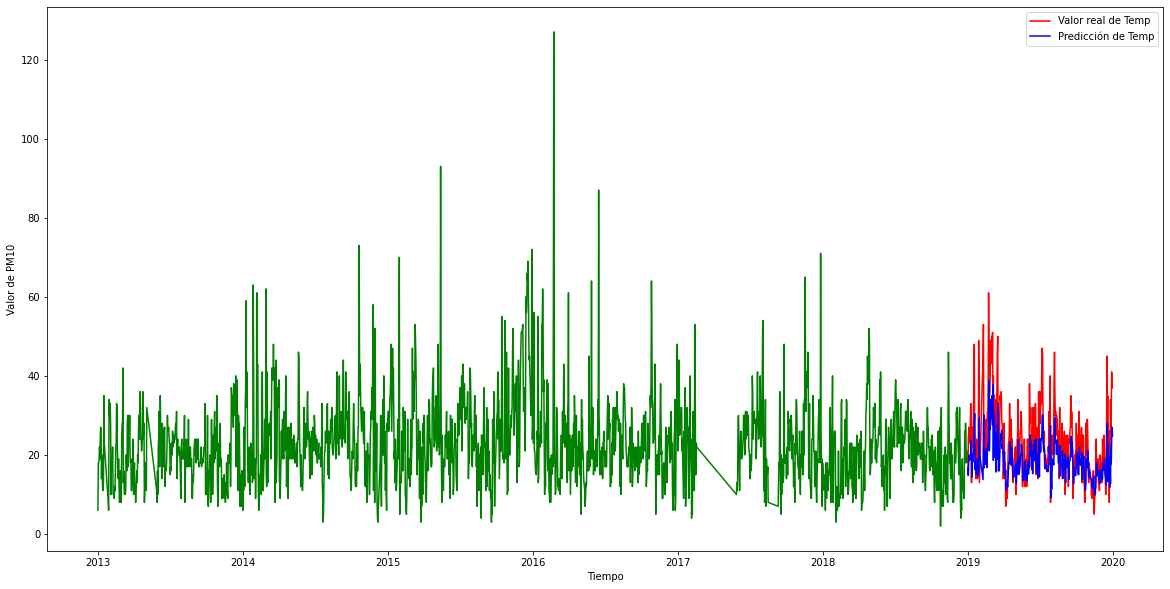

In [49]:
plt.plot(train[atributo], color='green')
plt.plot(resultados[atributo], color='red', label='Valor real de Temp')
plt.plot(resultados['Prediccion'], color='blue', label='Predicción de Temp')
# plt.ylim(1.1 * np.min(resultados['Prediccion'])/2, 1.1 * np.max(resultados['Prediccion']))
plt.xlabel('Tiempo')
plt.ylabel('Valor de ' + atributo)
plt.legend()
plt.show()

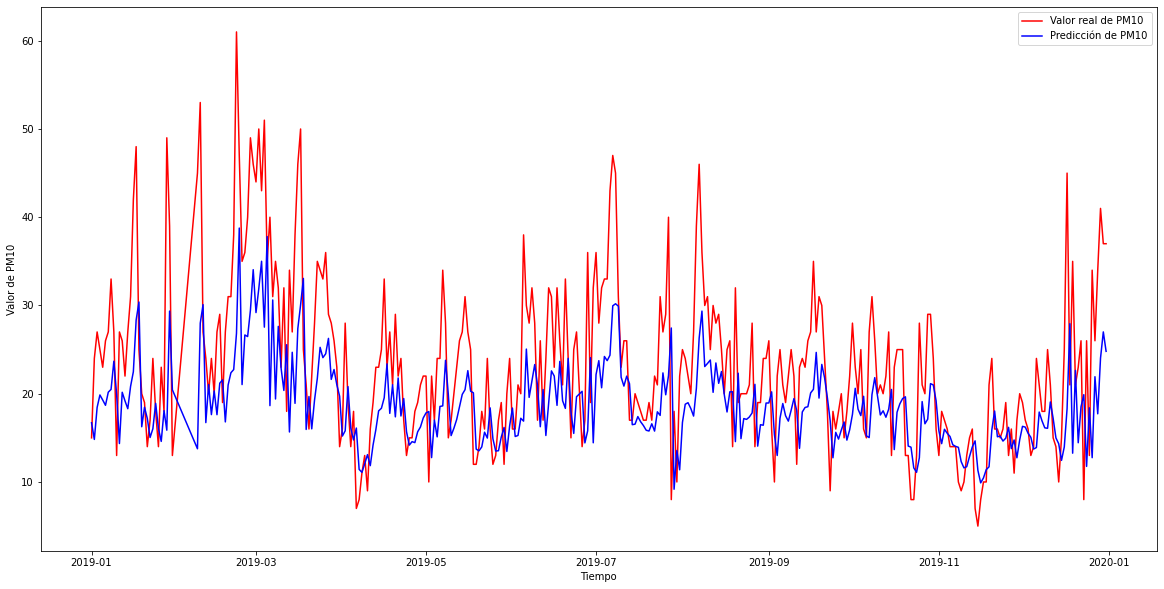

In [50]:
plt.plot(resultados[atributo], color='red', label='Valor real de ' + atributo)
plt.plot(resultados['Prediccion'], color='blue', label='Predicción de ' + atributo)
plt.xlabel('Tiempo')
plt.ylabel('Valor de ' + atributo)
plt.legend()
plt.show()

In [51]:
from sklearn.metrics import mean_absolute_error

# Error absoluto medio en la predicción

print('Error absoluto medio en la predicción', mean_absolute_error(resultados[atributo], resultados['Prediccion']))

Error absoluto medio en la predicción 6.6597598804516736


In [60]:
# Evaluar el modelo con el conjunto de test

test_scaled = sc.fit_transform(test)

# Hay que crear una estructura de datos para indicarle a la red los datos de la ventana de entrada
# y los datos de la ventana de salida
X_test = []
y_test = []

# Estructura de datos con "n" pasos y un ventSalida valores de salida
# "n" timesteps significa que para un día dado la red es capaz de mirar los "n" días anteriores:
# "n" valores anteriores al día actual y en base a esa información predice los "ventSalida" valores futuros 
for i in range(n,len(test_scaled)):
    # X: para cada día hacemos un bloque correspondiente al valor de los "n" días anteriores
    X_test.append(test_scaled[i-n:i,0])
    # Y: el valor del día
    y_test.append(test_scaled[i,0])

# Tenemos una matriz donde cada fila contiene "n" columnas correspondientes a los "n" días anteriores
X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape X_test para que se ajuste al modelo en Keras
# añadiendo una nueva dimensión 
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
print(y_test.shape)
modelo.evaluate(x=X_test, y=y_test, return_dict=True)

(356, 30, 1)
(356,)
12/12 [==============================] - 0s 19ms/step - loss: 0.0240


{'loss': 0.023990804329514503}

In [54]:
X_test

array([[[0.28070175],
        [0.47368421],
        [0.38596491],
        ...,
        [0.29824561],
        [0.24561404],
        [0.26315789]],

       [[0.47368421],
        [0.38596491],
        [0.49122807],
        ...,
        [0.24561404],
        [0.26315789],
        [0.19298246]],

       [[0.38596491],
        [0.49122807],
        [0.35087719],
        ...,
        [0.26315789],
        [0.19298246],
        [0.35087719]],

       ...,

       [[0.22807018],
        [0.28070175],
        [0.26315789],
        ...,
        [0.52631579],
        [0.38596491],
        [0.52631579]],

       [[0.28070175],
        [0.26315789],
        [0.22807018],
        ...,
        [0.38596491],
        [0.52631579],
        [0.64912281]],

       [[0.26315789],
        [0.22807018],
        [0.21052632],
        ...,
        [0.52631579],
        [0.64912281],
        [0.57894737]]])

In [55]:
y_test

array([0.19298246, 0.35087719, 0.40350877, 0.36842105, 0.33333333,
       0.38596491, 0.40350877, 0.50877193, 0.40350877, 0.15789474,
       0.40350877, 0.38596491, 0.31578947, 0.40350877, 0.47368421,
       0.66666667, 0.77192982, 0.36842105, 0.28070175, 0.26315789,
       0.1754386 , 0.22807018, 0.35087719, 0.24561404, 0.1754386 ,
       0.33333333, 0.24561404, 0.78947368, 0.61403509, 0.15789474,
       0.71929825, 0.85964912, 0.40350877, 0.35087719, 0.28070175,
       0.35087719, 0.28070175, 0.40350877, 0.43859649, 0.26315789,
       0.40350877, 0.47368421, 0.47368421, 0.59649123, 1.        ,
       0.75438596, 0.54385965, 0.56140351, 0.63157895, 0.78947368,
       0.73684211, 0.70175439, 0.80701754, 0.68421053, 0.8245614 ,
       0.54385965, 0.63157895, 0.47368421, 0.54385965, 0.49122807,
       0.33333333, 0.49122807, 0.24561404, 0.52631579, 0.40350877,
       0.59649123, 0.73684211, 0.80701754, 0.36842105, 0.29824561,
       0.21052632, 0.31578947, 0.42105263, 0.54385965, 0.52631